# notes
* Set up the GPU for OpenCL and create a GPU Context 

In [12]:
#Lets have matplotlib "inline"
%pylab inline

#Lets have opencl ipython integration enabled
%load_ext pyopencl.ipython_ext

#Import packages we need
import numpy as np
import pyopencl as cl

#Make sure we get compiler output from OpenCL
import os
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "1"

Populating the interactive namespace from numpy and matplotlib
The pyopencl.ipython_ext extension is already loaded. To reload it, use:
  %reload_ext pyopencl.ipython_ext


In [13]:
#Create OpenCL context
cl_ctx = cl.create_some_context()

#Create an OpenCL command queue
cl_queue = cl.CommandQueue(cl_ctx)

# notes
* Make a GPU kernel for 2d heat equation

In [14]:
%%cl_kernel 
__kernel void heat_eq_2D(__global float *u1, __global const float *u0,
float kappa, float dt, float dx, float dy) {
    
    //Get total number of cells
    int nx = get_global_size(0);
    int ny = get_global_size(1);
    
    int i = get_global_id(0); 
    int j = get_global_id(1);
    
    //Calculate the four indices of our neighboring cells
    int center = j*nx + i;
    int north = (j+1)*nx + i; 
    int south = (j-1)*nx + i; 
    int east = j*nx + i + 1;
    int west = j*nx + i -1;
    
    //Internal cells
    if (i > 0 && i < nx-1 && j > 0 && j <ny-1) {
        u1[center] = u0[center] + kappa*dt/(dx*dx) * (u0[east]-2*u0[center]+u0[west])
                    + kappa*dt/(dy*dy) * (u0[south]-2*u0[center]+u0[north]);
    }
    //Boundary conditions (ghost cells)
    else {
        u1[center] = u0[center];
    }
}

# notes
* Initial Conditions and move data from CPU to GPU

In [21]:
nx = 100
ny =nx
kappa = 1.0
dx = 1.0
dy = 1.0
dt = 0.4 * min(dx*dx / (2.0*kappa), dy*dy / (2.0*kappa))
u0 = np.random.rand(ny, nx).astype(np.float32)

mf = cl.mem_flags

#Upload data to the device
u0_g = cl.Buffer(cl_ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=u0)
#Allocate output buffers
u1_g = cl.Buffer(cl_ctx, mf.READ_WRITE, u0.nbytes)

# notes 
* Run the kernel and download the results

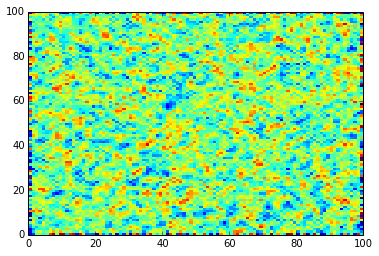

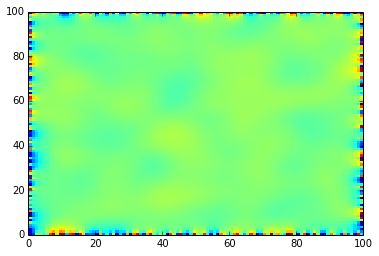

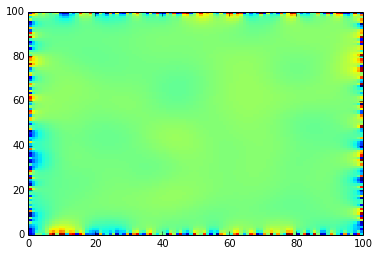

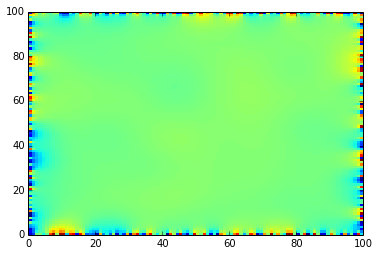

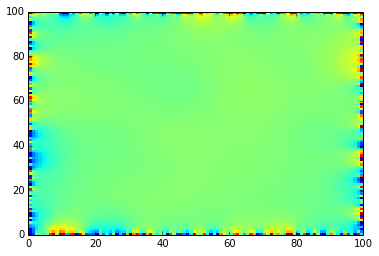

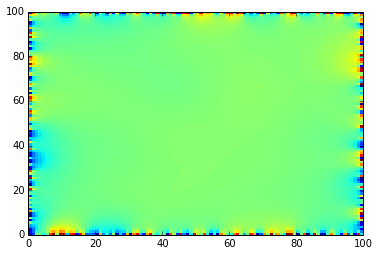

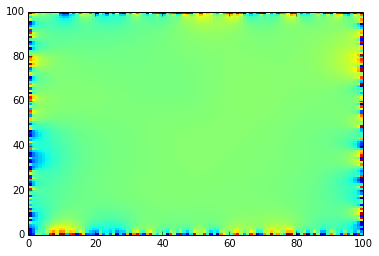

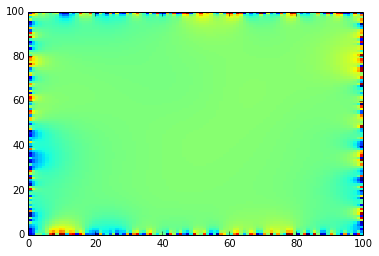

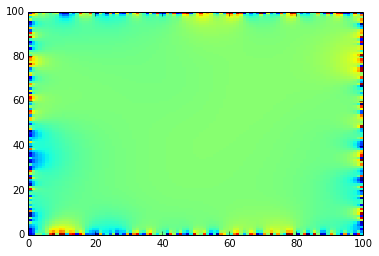

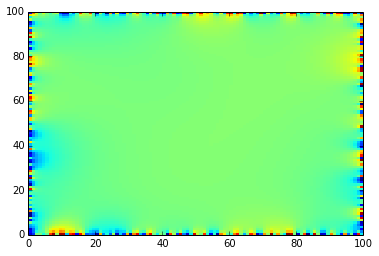

In [22]:



nt = 500
for i in range(0, nt):
    #Execute program on device
    heat_eq_2D(cl_queue, (nx, ny), None, u1_g, u0_g, numpy.float32(kappa), numpy.float32(dt), numpy.float32(dx), numpy.float32(dy))
    #Swap the two timesteps
    u0_g, u1_g = u1_g, u0_g
    #Plot results
    if (i % 50 == 0):
        figure()
        u0 = np.empty((nx, ny), dtype=np.float32)
        cl.enqueue_copy(cl_queue, u0, u0_g)
        pcolor(u0)
    
    
    



